# 1. Load functions

Load functions to run MINTsC. One would need to replace the directory "/storage10/kwangmoon/MINTsC" with their own directory where they cloned (or installed MINTsC). 


### Overview of the R scripts that is loaded

1. The **find_cliques.R** script conducts initial candidate clique search. It goes through entire cells in the scHi-C data and look for fully connected cliques. Hence, it might take some time for large datasets with high resoultion.

2. The **model_fit_porder.R** script implements the model fitting on the candidate cliques searched from the previous step. For each candidate clique satisfying some criterion given by MINTsC, e.g., genomic distance of locus pairs (of a clique) within lower and upper bound range given, we assigned p-score and Z-score defined in the MINTsC paper. 

3. The **significant_clique_caller.R'** script calculates p-values of the cliques based on the p-scores assigned from the previous step and calls significant cliques, i.e., MINTsC Multi-way interactions, based on FDR control. It also returns a QQplot for the p-values, along with Z-scores, FDR values.



In [1]:
source('/storage10/kwangmoon/MINTsC/code/functions/find_cliques.R')
source('/storage10/kwangmoon/MINTsC/code/functions/model_fit_porder.R')
source('/storage10/kwangmoon/MINTsC/code/functions/significant_clique_caller.R')    

# 2. Generate clique candiates

The code below searches all the fully connected cliques for each cell of the scHi-C data. The scHi-C data should be saved in **data_dir** and the resulting cliques across different sizes will be stored in **output_dir**. 

### Required data format

Before running the code below, the scHi-C data with supplementary information should be stored in the directory **data_dir**. Specifically, the data directory should contain 

1. Cell type data saved as **cell_type.qs** whose first column corresponds to a cell name and the second column correspons to the cell type label of the cell. The data should be saved in a **.qs** format supported by the R **qs** package.
2. Chromosome size file downloaded from external sources. e.g., hg19.chrom.sizes.
3. Subdirectories specific to all the chromosomes of the scHi-C data. 

For each subdirectory specific to each chromosome, the scHi-C data should be saved at a specific resolution for each cell type, either inferred before running MINTsC or already labelled from the scHi-C data. 

Each scHi-C data should be saved in a **.qs** format, and the the data should contain columns **chr, binA, binB, cc, cell, cluster, locipair**. Each row of the data corresponds to a loci-pair of the scHi-C data. The name of the data is expected to follow the format **hic_df_[chromosome]_[cell type].qs**

The specific information for the columns are as below: <br> 
**chr**: chromosome<br> 
**binA**: the first bin of the loci-pair (only the start location is recorded).<br> 
**binB**: the second bin of the loci-pair (binB should be greater than binA).<br> 
**cc**: Contact count for the loci pair.<br> 
**cell**: Cell label.<br> 
**cluster**: Cell type label.<br> 
**locipair**: loci pair.

As an example, take a look at the first 6 rows of the hic data of the first chromosome and GM12878 cell type.

In [3]:
library(qs)
hic_df_chr1=qread('/storage10/kwangmoon/MINTsC/data/Ramani2017/chr1/hic_df_chr1_GM12878.qs')
head(hic_df_chr1)

chr,binA,binB,cc,cell,cluster,locipair
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1,46500000,50500000,1,GM12878_1,GM12878,chr1_46500000-chr1_50500000
chr1,214000000,214000000,2,GM12878_1,GM12878,chr1_214000000-chr1_214000000
chr1,66500000,66500000,1,GM12878_1,GM12878,chr1_66500000-chr1_66500000
chr1,98500000,98500000,1,GM12878_1,GM12878,chr1_98500000-chr1_98500000
chr1,71000000,92500000,1,GM12878_1,GM12878,chr1_71000000-chr1_92500000
chr1,117500000,117500000,1,GM12878_1,GM12878,chr1_117500000-chr1_117500000


When the data_dir is ready, make an empty **output_dir** and run the following code. Depending on the resolution and the size of the data, it might take some time to run.

In [ ]:
find_cliques(data_dir='/storage10/kwangmoon/MINTsC/data/Ramani2017/',
             output_dir='/storage10/kwangmoon/MINTsC/results/Ramani2017/')

### Details on the arguements of the find_cliques function

**binsize**: Resolution of each bin of the lociapir. Default value is **500000**. 
<br>
**data_dir**: Name of the directory containing the scHi-C datasets (saved in subdirectories specific to chromosomes), cell type information, and chromosome size information.
<br>
**output_dir**: Name of the output directory, where the candidate cliques will be stored.
<br>
**corenum_celltype**: Number of cores used for a parallel process of cell types. If a too large value is fed in, it might not run. Default value is **1**.
<br>
**corenum_cells**: Number of cores used for a parallel process of cells. Default value is **20**.
<br>
**chrnum**: Number of chromosomes. For humans 23 and for mouse 20 is typically used. Default value is **23**.
<br>
**sizefile**: chromosome size file name. Default value is **hg19.chrom.sizes**.
<br>
**ncellsthreshold_c0**: Thresholding number of cells for size 3 cliques.  Default value is **1**.<br>
**ncellsthreshold_c1**: Thresholding number of cells for higher order cliques.  Default value is **0**. 
<br>
**Smax**: Maximum size of cliques to be searched within each cell. Default value is **10**.<br>
**chrlist**: List of chromosomes considered. e.g., "chr1","chr2",...,"chr22","chrX".  Default value is **NULL**. In case it is NULL, the list of chromosomes will be automatically generated based on the **chrnum** argument. 
<br>

# 3. Generate clique scores

The code below first retains cliques, whose entire loci pairs are have genomic distance within the specified range. Then, it assigns p-score and Z-score to each candidate clique identified from the previous code.

### Required data format

On top of the scHi-C data and supplementary information (already stored in **data_dir**) used for the candidate clique search in the previous step, the code below neccessiates groups of files in the directory **output_dir** as below: 

1. **Q[clique size]_filtered_list.qs**: This file contains the entire cliques searched from the previous code, across clique sizes.
2. **pairwise[clique size]_filtered_list.qs**: This file contains the pairwise interactions (loci pairs) of the cliques identified from the previous code, across clique sizes.

The files above will be automatically generated from the previous code. 

Now, run the code below to generate clique scores.


In [ ]:
P_value_generate(data_dir='/storage10/kwangmoon/MINTsC/data/Ramani2017/',
                 output_dir='/storage10/kwangmoon/MINTsC/results/Ramani2017/')

### Details on the arguements of the P_value_generate function


**binsize**: Resolution of each bin of the lociapir. Default value is **500000**. 
<br>
**data_dir**: Name of the directory containing the scHi-C datasets (saved in subdirectories specific to chromosomes), cell type information, and chromosome size information.
<br>
**output_dir**: Name of the output directory, where the candidate cliques is be stored.
<br>
**Smin**: Minimum clique size considered. Default value is **3**
<br>
**Smax**: Maximum clique size considered. Default value is **5**
<br>
**r_lists**: The order statistic number $r$ used for p-score generation across clique sizes. The length of the list should be the same as the number of clique sizes considered ($Smax-Smin+1$). Default value is **NULL**. If NULL, $r=\mbox{clique size}-1$ will be used.
<br>
**lower**: Lower bound for a loci pair's genomic distance within a candidate clique. Default value is **1**. Here, 1 means $1*binsize$ (meaning first off-diagonal). 2 would mean $2*binsize$.
<br>
**upper**: Upper bound for a loci pair's genomic distance within a candidate clique. Default value is **NULL**. Likewise, 1 means $1*binsize$. A value other than NULL (Greater than 1)should be given if the **automate_upper** argument is not set as **TRUE**
<br>
**automate_upper**: Indicator telling whether or not a user would want to automize the selection of upper based on the scHi-C data. Default value is **TRUE**.
<br>
**corenum_celltype**: Number of cores used for a parallel process of cell types. If a too large value is fed in, it might not run. Default value is **1**.
<br>
**corenum_optim**: Number of cores used for a parallel process of MINTsC optimization. Default value is **20**.
<br>
**corenum_chr**: Number of cores used for a parallel process of chromosoes. Default value is **1**.
<br>
**chrnum**: Number of chromosomes. For humans 23 and for mouse 20 is typically used. Default value is **23**.
<br>
**sizefile**: chromosome size file name. Default value is **hg19.chrom.sizes**.
<br>
**Smax**: Maximum size of cliques to be searched within each cell. Default value is **10**.
<br>
**chrlist**: List of chromosomes considered. e.g., "chr1","chr2",...,"chr22","chrX".  Default value is **NULL**. In case it is NULL, the list of chromosomes will be automatically generated based on the **chrnum** argument. 
<br>
**chrlevel_data.exist**: Indicator telling whether or not there already exists a chromosome specific **.qs** file in **output_dir**. Default value is **FALSE**. If False, the code will generate them. 
<br>
**L**: The number of basis functions in the natural cubin spline. Default value is **20**.
<br>
**tau**: Threshold parameter $\tau$ for the credible non-zero sets $A_j$ in the prior. Default value is **0**.
<br>
**epsilon**: Pseudo-count $\epsilon$ for the piror. For details, refer to the original paper's Method section. Default value is **0.00001**.
<br>
**cell_type_file**: Name of the cell type file, in case one wants to work on specific cell types instead of all of them. Default value is **NULL**. If it's NULL, the original cell type file with the name **cell_type.qs** will be utilized.



# 4. Call significant cliquesand draw QQplot of p-values

Now that the p-scores (or z-scores) are ready, we can call multi-way interactions based on clique p-values calculated from p-scores. The clique p-value can be adjusted by any type of method.

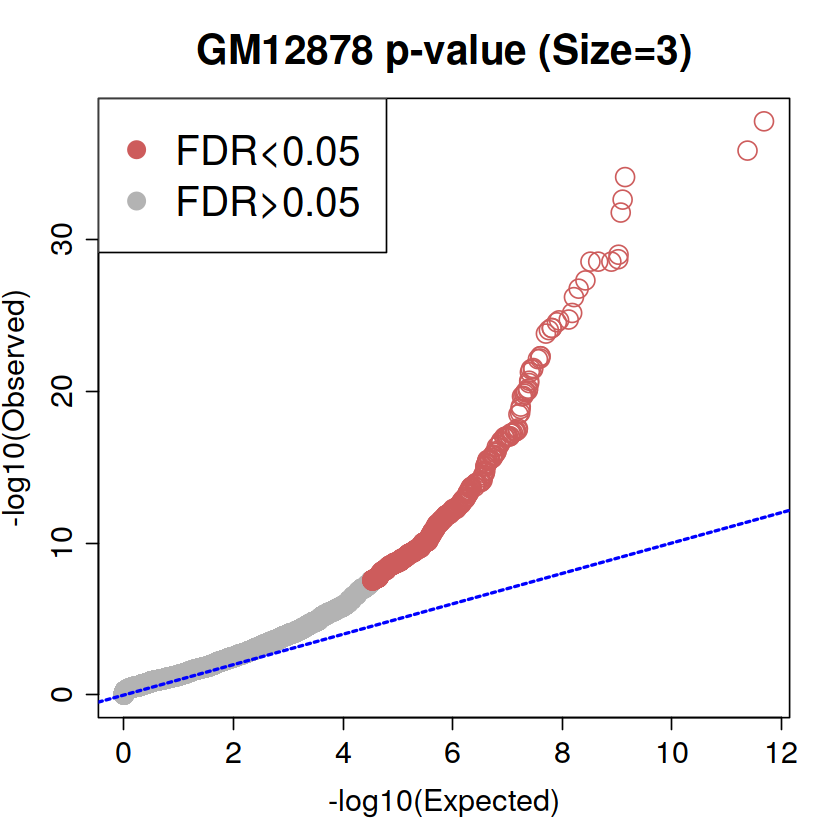

In [4]:
data=significant_clique_caller(output_dir="/storage10/kwangmoon/MINTsC/results/Ramani2017/",
                               chrlist=c(paste0("chr",c(1:22,"X"))),
                               S=3,
                               r=2,
                               cell_type="GM12878",
                               plot.it=TRUE)

### Details on the arguements of the significant_clique_caller function

**output_dir**: Name of the output directory. Use the same directory as the previous one's **output_dir** argument.
<br>
**S**: Size of the cliques considered. Default value is **3**.
<br>
**r**: order statistics value $r$.
<br>
**cell_type**: Cell type to be considered.
<br>
**fdr_cutoff**: False Dicovery Rate (FDR) cut off. Default value is **0.05**
<br> 
**plot.it**: Indicator telling whether or not a user wants to draw a QQplot out of clique p-values. Default value is **TRUE**
<br>
**chrlist**: List of chromosomes to consider. Default is a vector with entire chromosomes $c(chr1,chr2,\cdots,chr22,chrX)$
<br>
**p.adjust.method**: P-value adjustment method to be used. Default is **BH**

In [5]:
data %>% head

,clique,pscore,zscore,pvalue,fdr,multiway_interaction
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,chr1_1000000-chr1_1500000-chr1_2000000,0.7566,-0.6956,0.8512,0.8572,FALSE
2,chr1_10000000-chr1_10500000-chr1_11000000,0.5674,-0.1697,0.6004,0.7120,FALSE
3,chr1_10000000-chr1_10500000-chr1_11500000,0.2478,0.6813,0.1538,0.6803,FALSE
4,chr1_10000000-chr1_11000000-chr1_11500000,0.2546,0.6601,0.1614,0.6803,FALSE
5,chr1_100000000-chr1_100500000-chr1_101000000,0.2546,0.6601,0.1614,0.6803,FALSE
6,chr1_100000000-chr1_100500000-chr1_101500000,0.3696,0.3330,0.3088,0.6803,FALSE


### Details on output data frame

The resulting data frame from the function contains clique name, p-score, z-score, p-value, fdr, and indicator for multi-way interaction.